In [1]:
# Ni Utils
from nilearn.datasets import fetch_spm_auditory
from nilearn.plotting import plot_anat, plot_img, plot_stat_map, plot_contrast_matrix
from nilearn.image import concat_imgs, mean_img
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.glm import threshold_stats_img

# Sklearn Utils
from sklearn.decomposition import PCA

# Sci Utils
from scipy.stats import gamma

# Plotting Utils
from nilearn.plotting import plot_design_matrix
import matplotlib.pyplot as plt

# Table Utils
import pandas as pd

import numpy as np

In [2]:
subject_data = fetch_spm_auditory()

In [3]:
fmri_img = concat_imgs(subject_data.func)
mean_img = mean_img(fmri_img)
events = pd.read_table(subject_data["events"])
events

,onset,duration,trial_type
0,0.0,42.0,rest
1,42.0,42.0,active
2,84.0,42.0,rest
3,126.0,42.0,active
4,168.0,42.0,rest
5,210.0,42.0,active
6,252.0,42.0,rest
7,294.0,42.0,active
8,336.0,42.0,rest
9,378.0,42.0,active


In [4]:
# (x,y,z, signal)
#all_data = fmri_img.get_fdata()
#print(all_data.shape)
#print(all_data[0][0][0][0])

## Note: We can just directly get the design matrix

In [5]:
tr = 7
n_scans = fmri_img.shape[-1]
slice_time_ref = 0.0

start_time = slice_time_ref * tr
end_time = (n_scans - 1 + slice_time_ref) * tr
frame_times = np.linspace(start_time, end_time, n_scans)

X = make_first_level_design_matrix(
    frame_times=frame_times,
    events=events,
    hrf_model="spm",
    drift_model="cosine",
    high_pass=0.01,
)

In [6]:
X.shape # 96 data points comprised of 16 sessions (active, rest, drifts ....., constant)

(96, 16)

In [7]:
Y = fmri_img.get_fdata().reshape(-1, fmri_img.shape[-1]).T
Y.shape # To each data point we correspond the (x,y,z) signals reshaped as (x*y*z) to make the regression easy

(96, 262144)

In [8]:
def multi_sir(X, Y, n_slices=96, n_components=8, y_dim_reduced=10):

    if isinstance(X, pd.DataFrame):
        X = X.values

    X_centered = X
    Y_reduced = Y

    # Apply Multi-SIR
    # Initialize the array to store slice means
    slice_means = np.zeros((n_slices, X_centered.shape[1]))

    for i in range(n_slices):
        # Define the slice
        start_idx = i * Y_reduced.shape[0] // n_slices
        end_idx = (i + 1) * Y_reduced.shape[0] // n_slices

        # Sort X based on each dimension of Y_reduced and compute means
        for j in range(Y_reduced.shape[1]):
            sorted_idx = np.argsort(Y_reduced[start_idx:end_idx, j])
            slice_means[i, :] += X[start_idx:end_idx, :][sorted_idx].mean(axis=0)

    # Average the slice means
    slice_means /= Y_reduced.shape[1]

    # Step 3: PCA on slice means
    pca_x = PCA(n_components=n_components)
    X_reduced = pca_x.fit_transform(slice_means)

    return X_reduced


In [9]:
# Apply the function
# We don't want to reduce on active or rest or constant, we want to know how the drift affects Y
X_reduced = multi_sir(X.to_numpy()[:,2:len(X)-1], Y)

In [10]:
# Append active, rest and constant back
X_reduced = np.concatenate([X.to_numpy()[:,:2], X_reduced, X.to_numpy()[:,15:len(X)]], axis=1)

In [11]:
X_reduced_frame = pd.DataFrame(X_reduced)

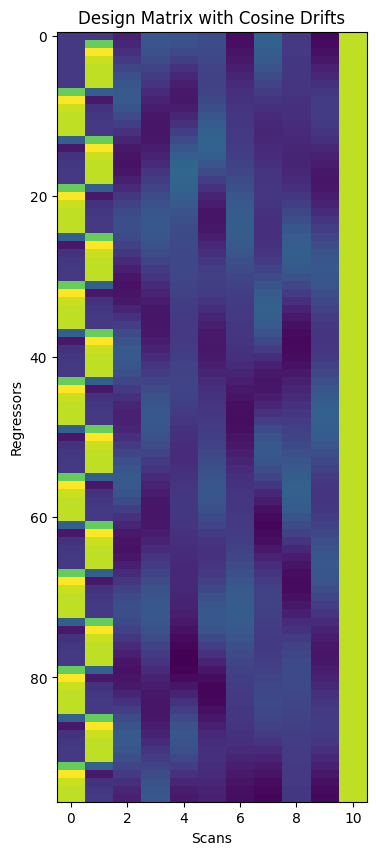

In [12]:
# Plot the design matrix
plt.figure(figsize=(4, 10))
plt.imshow(X_reduced_frame, aspect='auto')
plt.xlabel('Scans')
plt.ylabel('Regressors')
plt.title('Design Matrix with Cosine Drifts')
#plt.colorbar()
plt.show()


In [13]:
X_reduced_frame.iloc[[1,0]]

,0,1,2,3,4,5,6,7,8,9,10
1,0.0,0.817784,-0.080091,0.133500,0.113009,0.094036,-0.167275,0.193687,0.001770,-0.183228,1.0
0,0.0,0.000000,-0.100311,0.143254,0.132627,0.102116,-0.175126,0.202201,0.002773,-0.194144,1.0


In [14]:
fmri_glm = FirstLevelModel(
    t_r=7,                  # is the time of repetition of acquisitions
    noise_model="ar1",      # specifies the noise covariance model: lag-1 dependence
    standardize=False,      # we don't rescale the time series to mean 0, variance 1
    hrf_model="spm",        # we rely on the SPM (Statistical Parametric Mapping) model
    drift_model="cosine",   # we model the signal drifts as slow oscillating time functions
    high_pass=0.01,         # defines the cutoff frequency
)

In [15]:
fmri_glm = fmri_glm.fit(run_imgs=fmri_img, design_matrices = X_reduced_frame)

In [16]:
design_matrix = fmri_glm.design_matrices_[0]

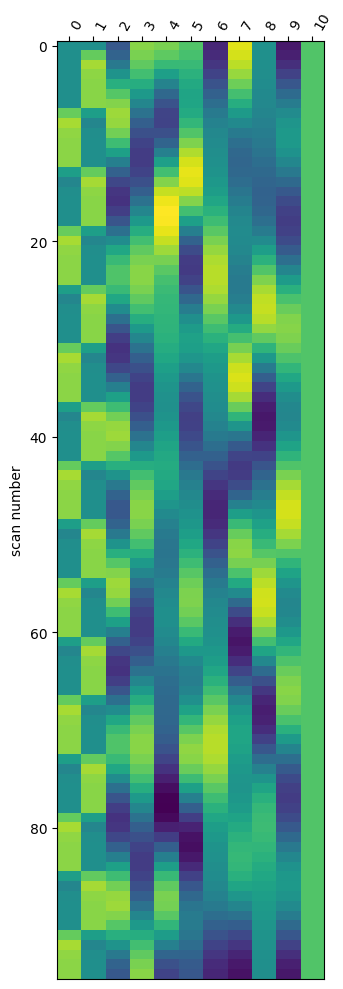

In [17]:
plot_design_matrix(design_matrix)
plt.show()

In [18]:
design_matrix.iloc[[1,0]]

,0,1,2,3,4,5,6,7,8,9,10
1,0.0,0.817784,-0.080091,0.133500,0.113009,0.094036,-0.167275,0.193687,0.001770,-0.183228,1.0
0,0.0,0.000000,-0.100311,0.143254,0.132627,0.102116,-0.175126,0.202201,0.002773,-0.194144,1.0


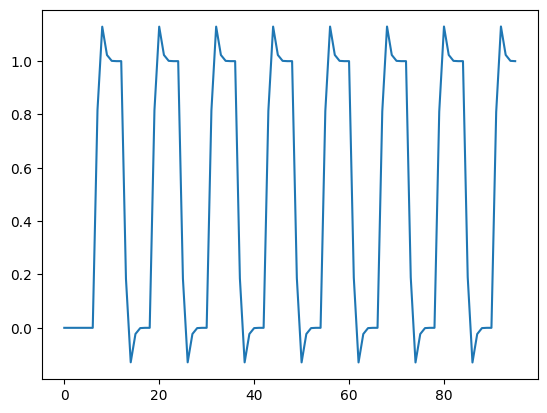

In [19]:
plt.plot(design_matrix.iloc[:,0])

In [20]:
# Compute Contrast
conditions = {"active": np.zeros(11), "rest": np.zeros(11)} # was 8
conditions["active"][0] = 1
conditions["rest"][1] = 1
active_minus_rest = conditions["active"] - conditions["rest"]

<AxesSubplot: label='conditions'>

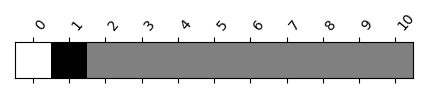

In [21]:
plot_contrast_matrix(active_minus_rest, design_matrix=design_matrix)

In [22]:
#Below, we compute the ‘estimated effect’. 
#It is in BOLD signal unit, but has no statistical guarantees, 
#because it does not take into account the associated variance.
eff_map = fmri_glm.compute_contrast(
    active_minus_rest, output_type="effect_size"
)

In [23]:
#In order to get statistical significance, we form a t-statistic, and directly convert it into z-scale.
#The z-scale means that the values are scaled to match a standard Gaussian distribution (mean=0, variance=1),
#across voxels, if there were no effects in the data.
z_map = fmri_glm.compute_contrast(active_minus_rest, output_type="z_score")

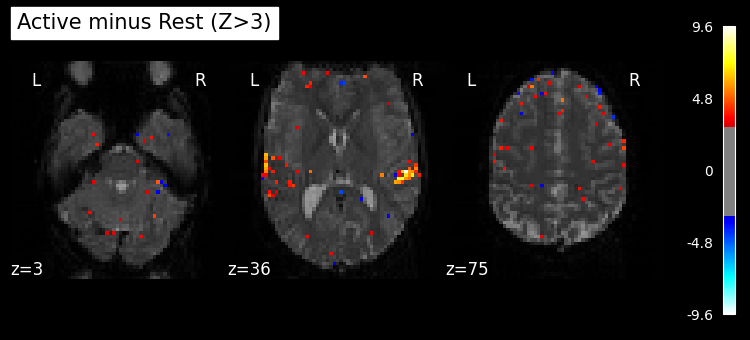

In [24]:
plot_stat_map(
    z_map,
    bg_img=mean_img,
    threshold=3.0,
    display_mode="z",
    cut_coords=3,
    black_bg=True,
    title="Active minus Rest (Z>3)",
)
plt.show()

Uncorrected p<0.001 threshold: 3.291


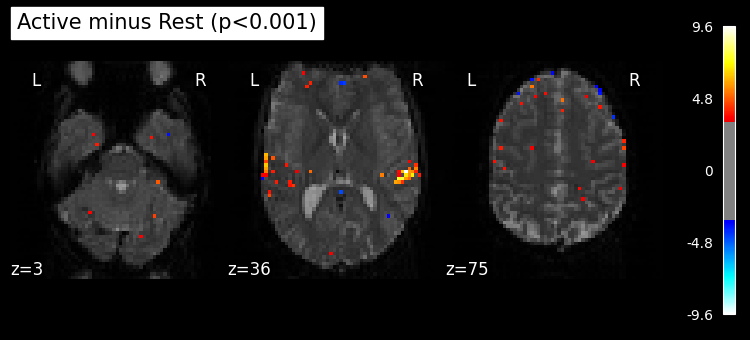

In [25]:
#Statistical significance testing. One should worry about the statistical validity of the procedure: 
#here we used an arbitrary threshold of 3.0 but the threshold should provide some guarantees on the risk of false detections 
#(aka type-1 errors in statistics). One suggestion is to control the false positive rate (fpr, denoted by alpha) at a certain level,
# e.g. 0.001: this means that there is 0.1% chance of declaring an inactive voxel, active.


_, threshold = threshold_stats_img(z_map, alpha=0.001, height_control="fpr")
print(f"Uncorrected p<0.001 threshold: {threshold:.3f}")
plot_stat_map(
    z_map,
    bg_img=mean_img,
    threshold=threshold,
    display_mode="z",
    cut_coords=3,
    black_bg=True,
    title="Active minus Rest (p<0.001)",
)
plt.show()

Bonferroni-corrected, p<0.05 threshold: 4.934


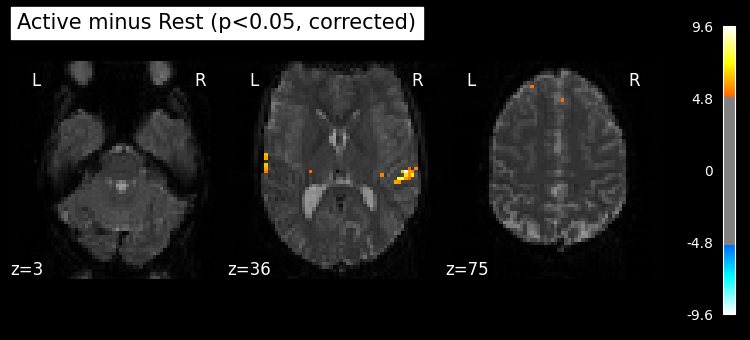

In [26]:
#The problem is that with this you expect 0.001 * n_voxels to show up while they’re not active — tens to hundreds of voxels.
# A more conservative solution is to control the family wise error rate, i.e. the probability of making only one false detection,
#say at 5%. For that we use the so-called Bonferroni correction.
_, threshold = threshold_stats_img(
    z_map, alpha=0.05, height_control="bonferroni"
)
print(f"Bonferroni-corrected, p<0.05 threshold: {threshold:.3f}")
plot_stat_map(
    z_map,
    bg_img=mean_img,
    threshold=threshold,
    display_mode="z",
    cut_coords=3,
    black_bg=True,
    title="Active minus Rest (p<0.05, corrected)",
)
plt.show()

False Discovery rate = 0.05 threshold: 3.451


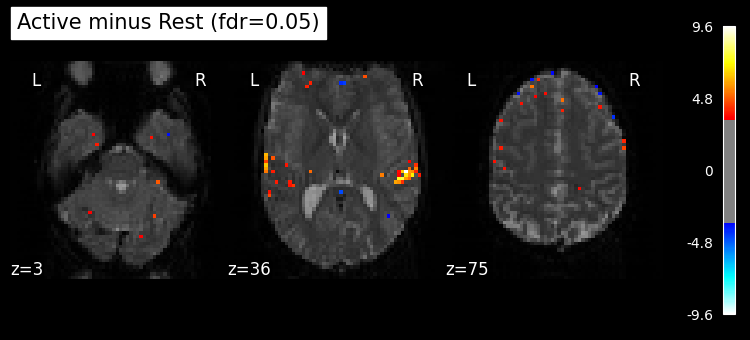

In [27]:
#This is quite conservative indeed! A popular alternative is to control the expected proportion 
#of false discoveries among detections. This is called the False discovery rate.
_, threshold = threshold_stats_img(z_map, alpha=0.05, height_control="fdr")
print(f"False Discovery rate = 0.05 threshold: {threshold:.3f}")
plot_stat_map(
    z_map,
    bg_img=mean_img,
    threshold=threshold,
    display_mode="z",
    cut_coords=3,
    black_bg=True,
    title="Active minus Rest (fdr=0.05)",
)
plt.show()

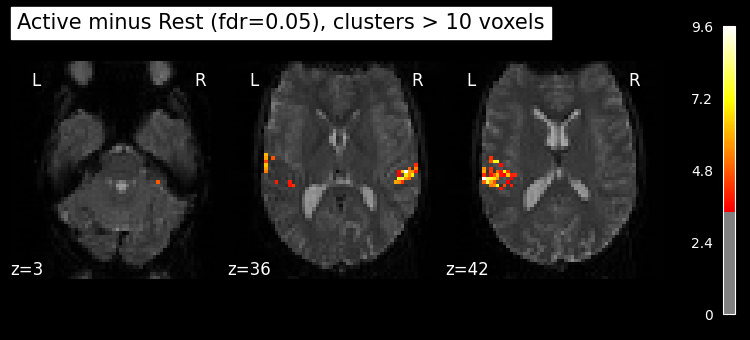

In [28]:
#Finally people like to discard isolated voxels (aka “small clusters”) from these images. It is possible to generate a thresholded 
#map with small clusters removed by providing a cluster_threshold argument. Here clusters smaller than 10 voxels will be discarded.
clean_map, threshold = threshold_stats_img(
    z_map, alpha=0.05, height_control="fdr", cluster_threshold=10
)
plot_stat_map(
    clean_map,
    bg_img=mean_img,
    threshold=threshold,
    display_mode="z",
    cut_coords=3,
    black_bg=True,
    title="Active minus Rest (fdr=0.05), clusters > 10 voxels",
)
plt.show()

In [29]:
from nilearn.reporting import get_clusters_table

table = get_clusters_table(
    z_map, stat_threshold=threshold, cluster_threshold=20
)
table

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,-63.0,-6.0,42.0,9.599473,2538
1,1a,-48.0,-15.0,39.0,8.248213,
2,1b,-63.0,18.0,33.0,8.234333,
3,1c,-54.0,9.0,42.0,7.415255,
4,2,60.0,0.0,36.0,9.549298,891
5,3,66.0,15.0,27.0,7.892324,540
6,3a,51.0,3.0,30.0,6.354183,
7,3b,57.0,12.0,30.0,5.885941,
8,4,39.0,-6.0,15.0,6.644320,810
9,4a,30.0,-9.0,12.0,6.083158,


In [31]:
table.to_csv("./table_sir.csv")